In [13]:
import os
import torch as tr
import numpy as np
import matplotlib.pyplot as plt
from omegaconf import OmegaConf
from pathlib import Path

from vre.representations import build_representations_from_cfg
from vre.utils import get_project_root, FFmpegVideo
from vre_repository import get_vre_repository

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
video = FFmpegVideo(get_project_root() / "resources/test_video.mp4")
print(video.shape, video.fps)

(5395, 720, 1280, 3) 29.97002997002997


In [ ]:
os.environ["VRE_DEVICE"] = device = "cuda" if tr.cuda.is_available() else "cpu"
all_representations_dict = OmegaConf.load(open(Path.cwd() / "cfg.yaml", "r"))

device = "cuda" if tr.cuda.is_available() else "cpu"

representations = build_representations_from_cfg(all_representations_dict, representation_types=get_vre_repository())
name_to_repr = {r.name: r for r in representations}
print(representations)

[2025-02-02T10:09:07 VRE-DEBUG] Doing topological sort... (build_representations.py:build_representations_from_cfg:83)
[2025-02-02T10:09:07 VRE-INFO] Building 'depth/dpt' (vre name: depth_dpt) (build_representations.py:build_representation_from_cfg:46)
[2025-02-02T10:09:07 VRE-DEBUG] [DepthDpt(depth_dpt)] Set node specific 'Learned' params: 
-device: cuda (learned_representation_mixin.py:set_learned_params:58)
[2025-02-02T10:09:07 VRE-INFO] Building 'depth/marigold' (vre name: depth_marigold) (build_representations.py:build_representation_from_cfg:46)
[2025-02-02T10:09:07 VRE-DEBUG] [Marigold(depth_marigold)] Set node specific 'Learned' params: 
-device: cuda (learned_representation_mixin.py:set_learned_params:58)
[2025-02-02T10:09:07 VRE-INFO] Building 'normals/depth-svd' (vre name: normals_svd(depth_marigold)) (build_representations.py:build_representation_from_cfg:46)


[DepthDpt(depth_dpt), Marigold(depth_marigold), DepthNormalsSVD(normals_svd(depth_marigold) ['depth_marigold'])]


## Run the representations for two particular frame

[2303, 3392]


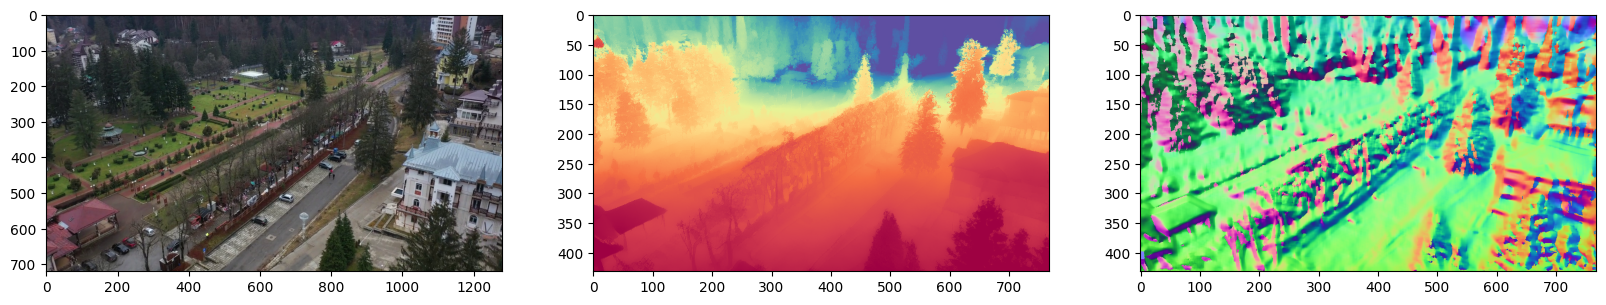

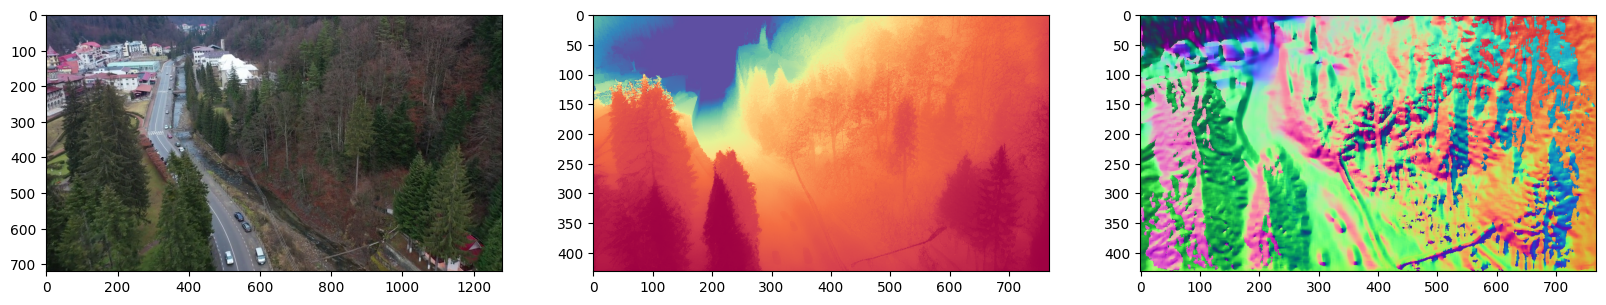

In [18]:
# inference setup (this is done inside VRE's main loop at run() as well)
depth, normals = name_to_repr["depth_marigold"], name_to_repr["normals_svd(depth_marigold)"]
depth.vre_setup() if depth.setup_called is False else None

np.random.seed(43)
mb = 2
ixs = sorted([np.random.randint(0, len(video) - 1) for _ in range(mb)])
print(ixs)

depth.data = normals.data = None
depth.compute(video, ixs)
normals.compute(video, ixs)
y_depth_img = depth.make_images(depth.data)
y_normals_img = normals.make_images(normals.data)
for i in range(mb):
    fig, ax = plt.subplots(1, 3, figsize=(20, 10))
    ax[0].imshow(depth.data.frames[i])
    ax[1].imshow(y_depth_img[i])
    ax[2].imshow(y_normals_img[i])
    plt.show()
depth.vre_free()